In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from seiz_eeg.dataset import EEGDataset
from sklearn.metrics import f1_score, recall_score, precision_score

In [3]:
data_path = "data/"  # Replace with your data root path
DATA_ROOT = Path(data_path)
sample_rate = 250
segment_length = 3000

In [108]:
def create_spectrogram(x: np.ndarray):
    spectrograms = []
    for i in range(x.shape[1]):
        f, t, Sxx = signal.spectrogram(
            x[:, i], fs=sample_rate,
            nperseg=256, noverlap=192
        )
        # Keep only to 30 Hz
        mask = (f <= 30)
        Sxx = Sxx[mask, :]
        Sxx = np.log(Sxx + 1e-8)  # Log transform
        spectrograms.append(Sxx)
    spec_array = np.stack(spectrograms, axis=0)
    return torch.tensor(spec_array, dtype=torch.float32)

In [109]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [110]:
train_dataset = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    signal_transform=create_spectrogram,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [111]:
from torch.utils.data import random_split

total_len = len(train_dataset)
train_len = int(0.8 * total_len)
val_len = total_len - train_len

# Randomly split
dataset_tr_split, dataset_val_split = random_split(train_dataset, [train_len, val_len])


In [112]:
train_loader = DataLoader(dataset_tr_split, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset_val_split, batch_size=64, shuffle=False)

In [113]:
class SpectrogramCNN(nn.Module):
    def __init__(self, in_channels=19):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(self.net(x))


In [114]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpectrogramCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25
train_losses = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(device)  # [B, 19, F, T]
        yb = yb.float().unsqueeze(1).to(device) # [B, 1]

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)  # [B, 19, F, T]
            yb = yb.float().unsqueeze(1).to(device) # [B, 1]
            logits = model(xb)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.4).float()

            # Flatten and collect predictions and labels
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(yb.view(-1).cpu().numpy())
    f1 = f1_score(all_labels, all_preds)
    val_f1s.append(f1)

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Val F1 Score: {f1:.4f}")

Epoch 1/25 - Loss: 0.3991, Val F1 Score: 0.4815
Epoch 2/25 - Loss: 0.3448, Val F1 Score: 0.5856
Epoch 3/25 - Loss: 0.3097, Val F1 Score: 0.6566
Epoch 4/25 - Loss: 0.2863, Val F1 Score: 0.6889
Epoch 5/25 - Loss: 0.2711, Val F1 Score: 0.7224
Epoch 6/25 - Loss: 0.2587, Val F1 Score: 0.7548
Epoch 7/25 - Loss: 0.2490, Val F1 Score: 0.7160
Epoch 8/25 - Loss: 0.2324, Val F1 Score: 0.6606
Epoch 9/25 - Loss: 0.2292, Val F1 Score: 0.7704
Epoch 10/25 - Loss: 0.2213, Val F1 Score: 0.7656
Epoch 11/25 - Loss: 0.2166, Val F1 Score: 0.7917
Epoch 12/25 - Loss: 0.2054, Val F1 Score: 0.7380
Epoch 13/25 - Loss: 0.2078, Val F1 Score: 0.7643
Epoch 14/25 - Loss: 0.2038, Val F1 Score: 0.7744
Epoch 15/25 - Loss: 0.1955, Val F1 Score: 0.7778
Epoch 16/25 - Loss: 0.1882, Val F1 Score: 0.7788
Epoch 17/25 - Loss: 0.1829, Val F1 Score: 0.7845
Epoch 18/25 - Loss: 0.1777, Val F1 Score: 0.7909
Epoch 19/25 - Loss: 0.1741, Val F1 Score: 0.7945
Epoch 20/25 - Loss: 0.1656, Val F1 Score: 0.7984
Epoch 21/25 - Loss: 0.1677, V

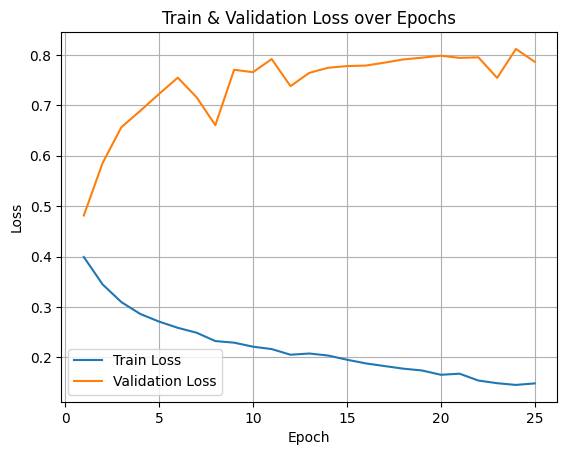

In [115]:
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [106]:
from sklearn.metrics import f1_score, recall_score, precision_score
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)  # [B, 19, F, T]
        yb = yb.float().unsqueeze(1).to(device) # [B, 1]
        logits = model(xb)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.2).float()

        # Flatten and collect predictions and labels
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(yb.view(-1).cpu().numpy())
f1 = f1_score(all_labels, all_preds)

print(f"Validation F1 Score: {f1:.4f}")

Validation F1 Score: 0.7606


In [107]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
recall = recall_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Validation Recall: {recall:.4f}")
print(f"Validation Precision: {precision:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Recall: 0.7444
Validation Precision: 0.7775
Validation Accuracy: 0.9111
